# Аналіз жестів руки: k-NN та k-means

**Об'єкт дослідження:** гіпотетичне зображення руки  
**Ознаки:** висота та ширина долоні (2D простір)  
**Класи:** Кулак, Долоня

In [1]:
import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Image

class RNG:
    def __init__(self, seed=42):
        self.state = seed
    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)
    def gauss(self, mu, sigma):
        u1, u2 = self.random(), self.random()
        return mu + sigma * math.sqrt(-2 * math.log(u1 + 1e-10)) * math.cos(2 * math.pi * u2)

rng = RNG(42)

def generate_class(n, cw, ch, sw, sh):
    return [(rng.gauss(cw, sw), rng.gauss(ch, sh)) for _ in range(n)]

# Fist: w/h ratio from 1.5 to 2.5, center at 2.0 -> w=8, h=4
fist_data = generate_class(30, 8, 4, 0.8, 0.9)
# Palm: w/h ratio from 0.9 to 1.1, center at 1.0 -> w=16, h=16
palm_data = generate_class(30, 16, 16, 1.5, 1.8)
X = fist_data + palm_data
y = [0]*30 + [1]*30

fist_w = [p[0] for p in fist_data]
fist_h = [p[1] for p in fist_data]
palm_w = [p[0] for p in palm_data]
palm_h = [p[1] for p in palm_data]

print(f"Згенеровано {len(X)} зразків: {len(fist_data)} кулак, {len(palm_data)} долоня")

Згенеровано 60 зразків: 30 кулак, 30 долоня


## 1. Приклади обмежувальних рамок (3 жести)

Розміри: КУЛАК 8x4cm (w/h=2.0), ДОЛОНЯ 16x16cm (w/h=1.0), ЗНАК ПЕРЕМОГИ 10x12cm (h/w=1.2)


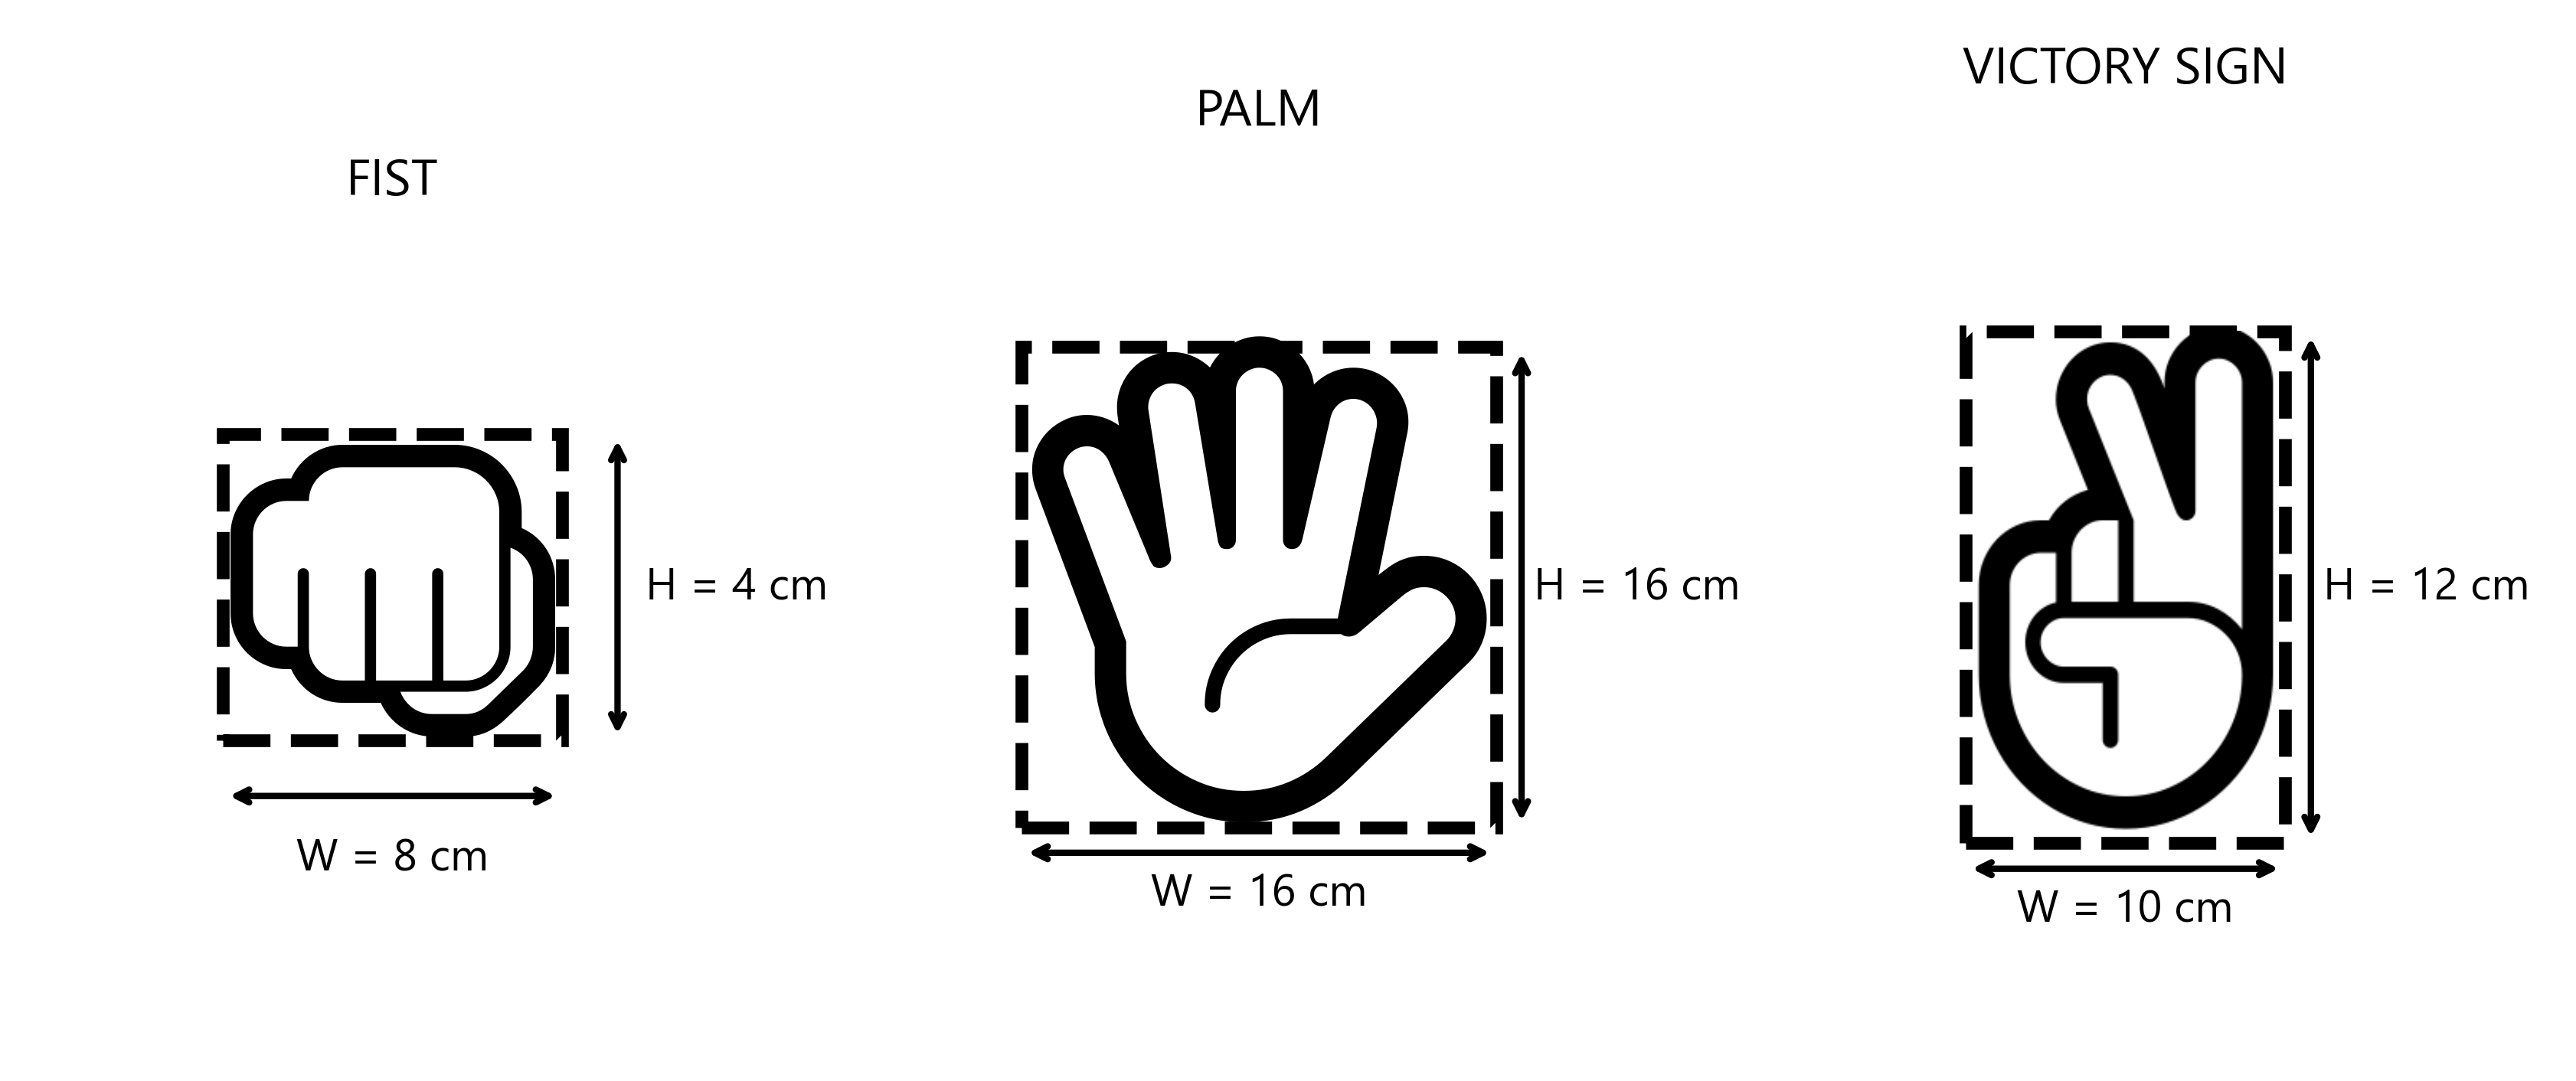

In [2]:
import sys
from IPython.display import display, Image
# -*- coding: utf-8 -*-
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import numpy as np
import os

import sys
BOX_COLOR = 'black'
plt.rcParams['font.family'] = 'Segoe UI Emoji'
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
TITLE_STYLE = dict(fontsize=16, fontweight='bold', color=BOX_COLOR)

def add_gesture(ax, emoji, center, fontsize, w_label, h_label, title):
    t = ax.text(center[0], center[1], emoji, fontsize=fontsize, ha='center', va='center', clip_on=False)
    ax.set_aspect('equal')
    ax.axis('off')
    return t, (w_label, h_label, title)

# FIST (w/h = 2.0, ratio range 1.5-2.5)
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
t1, (w1, h1, title1) = add_gesture(ax1, '\U0001F44A', (5, 5), 100, '8', '4', 'FIST')

# PALM (w/h = 1.0, ratio range 0.9-1.1)
ax2 = axes[1]
ax2.set_xlim(0, 22)
ax2.set_ylim(0, 26)
t2, (w2, h2, title2) = add_gesture(ax2, '\U0001F590', (11, 13), 140, '16', '16', 'PALM')

def get_glyph_image(char, fontsize=200):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.text(0.5, 0.5, char, fontsize=fontsize, ha='center', va='center', fontfamily='Segoe UI Emoji')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    buf.seek(0)
    img = imread(buf)
    
    # Crop to content
    # Assuming white background (1,1,1) or transparent
    if img.shape[2] == 4:
        alpha = img[:, :, 3]
        rows = np.any(alpha > 0, axis=1)
        cols = np.any(alpha > 0, axis=0)
    else:
        gray = img.mean(axis=2)
        rows = np.any(gray < 0.9, axis=1)
        cols = np.any(gray < 0.9, axis=0)
        
    if np.any(rows) and np.any(cols):
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return img[ymin:ymax+1, xmin:xmax+1]
    return img

# VICTORY SIGN - use image-based approach for perfect centering
ax3 = axes[2]
ax3.set_xlim(0, 20)
ax3.set_ylim(0, 28)
ax3.axis('off')

glyph_img = get_glyph_image('\u270C') # Use standard Victory Hand
# Center at (10, 14). Box is 10x20.
h_img, w_img = glyph_img.shape[:2]
aspect = h_img / w_img
    
# Victory sign box (match labels and report)
box_w = 10.0
box_h = 16.0

# Center: x=10, y=14
cx, cy = 10.0, 14.0
x0 = cx - box_w / 1.3
x1 = cx + box_w / 1.3
y0 = cy + box_h / 2
y1 = cy - box_h / 2

ax3.imshow(glyph_img, extent=[x0, x1, y1, y0], aspect='equal', interpolation='bilinear')
t3, w3, h3, title3 = None, '10', '12', 'VICTORY SIGN'

# Render to get text extents, then draw tight boxes
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

def draw_tight_box(ax, text_obj, w_label, h_label, title):
    bbox = text_obj.get_tightbbox(renderer=renderer) or text_obj.get_window_extent(renderer=renderer)
    bbox_data = bbox.transformed(ax.transData.inverted())
    x0, y0 = bbox_data.x0, bbox_data.y0
    w = bbox_data.width
    h = bbox_data.height

    w_inset = w * 0.12
    h_inset = h * 0.05
    x0 += w_inset
    y0 += h_inset
    w -= 2 * w_inset
    h -= 2 * h_inset

    rect = patches.Rectangle((x0, y0), w, h, fill=False, edgecolor=BOX_COLOR, linewidth=4, linestyle='--')
    ax.add_patch(rect)

    pad = 0.8
    y_arrow = y0 - pad
    ax.annotate('', xy=(x0, y_arrow), xytext=(x0 + w, y_arrow),
                arrowprops=dict(arrowstyle='<->', color=BOX_COLOR, lw=2))
    ax.text(x0 + w/2, y_arrow - 0.6, f'W = {w_label} cm', ha='center', va='top', fontsize=14, color=BOX_COLOR, fontweight='bold')

    x_arrow = x0 + w + pad
    ax.annotate('', xy=(x_arrow, y0), xytext=(x_arrow, y0 + h),
                arrowprops=dict(arrowstyle='<->', color=BOX_COLOR, lw=2))
    ax.text(x_arrow + 0.4, y0 + h/2, f'H = {h_label} cm', ha='left', va='center', fontsize=14, color=BOX_COLOR, fontweight='bold')


def draw_fixed_box(ax, x_center, y_center, w, h, w_label, h_label, title):
    # Calculate corner from center and dimensions
    x0 = x_center - w/2
    y0 = y_center - h/2
    
    rect = patches.Rectangle((x0, y0), w, h, fill=False, edgecolor=BOX_COLOR, linewidth=4, linestyle='--')
    ax.add_patch(rect)

    pad = 0.8
    y_arrow = y0 - pad
    ax.annotate('', xy=(x0, y_arrow), xytext=(x0 + w, y_arrow), arrowprops=dict(arrowstyle='<->', color=BOX_COLOR, lw=2))
    ax.text(x0 + w/2, y_arrow - 0.6, f'W = {w_label} cm', ha='center', va='top', fontsize=14, color=BOX_COLOR, fontweight='bold')

    x_arrow = x0 + w + pad
    ax.annotate('', xy=(x_arrow, y0), xytext=(x_arrow, y0 + h), arrowprops=dict(arrowstyle='<->', color=BOX_COLOR, lw=2))
    ax.text(x_arrow + 0.4, y0 + h/2, f'H = {h_label} cm', ha='left', va='center', fontsize=14, color=BOX_COLOR, fontweight='bold')
    # Title is drawn separately for consistent alignment across subplots

draw_tight_box(ax1, t1, w1, h1, title1)
draw_tight_box(ax2, t2, w2, h2, title2)
draw_fixed_box(ax3, 10, 14, box_w, box_h, w3, h3, title3)

fig.subplots_adjust(left=0.08, right=0.96, bottom=0.12, top=0.9, wspace=0.25)

# Draw titles at identical vertical positions for readability
for ax, title in zip(axes, [title1, title2, title3]):
    ax.text(0.5, 1.05, title, transform=ax.transAxes, ha='center', va='bottom', **TITLE_STYLE)

plt.savefig('box_examples.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.close()
if hasattr(sys.stdout, 'reconfigure'):
    sys.stdout.reconfigure(encoding='utf-8')
print("Розміри: КУЛАК 8x4cm (w/h=2.0), ДОЛОНЯ 16x16cm (w/h=1.0), ЗНАК ПЕРЕМОГИ 10x12cm (h/w=1.2)")

display(Image('box_examples.png'))


## 2. Візуалізація даних

C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\3525331897.py:9: UserWarning: Glyph 1064 (\N{CYRILLIC CAPITAL LETTER SHA}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\3525331897.py:9: UserWarning: Glyph 1080 (\N{CYRILLIC SMALL LETTER I}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\3525331897.py:9: UserWarning: Glyph 1088 (\N{CYRILLIC SMALL LETTER ER}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\3525331897.py:9: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\3525331897.py:9: UserWarning: Glyph 1072 (\N{CYRILLIC SMALL LETTER A}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\3525331897.py:9: UserWarning: Glyph 1042 (\N{CYRI

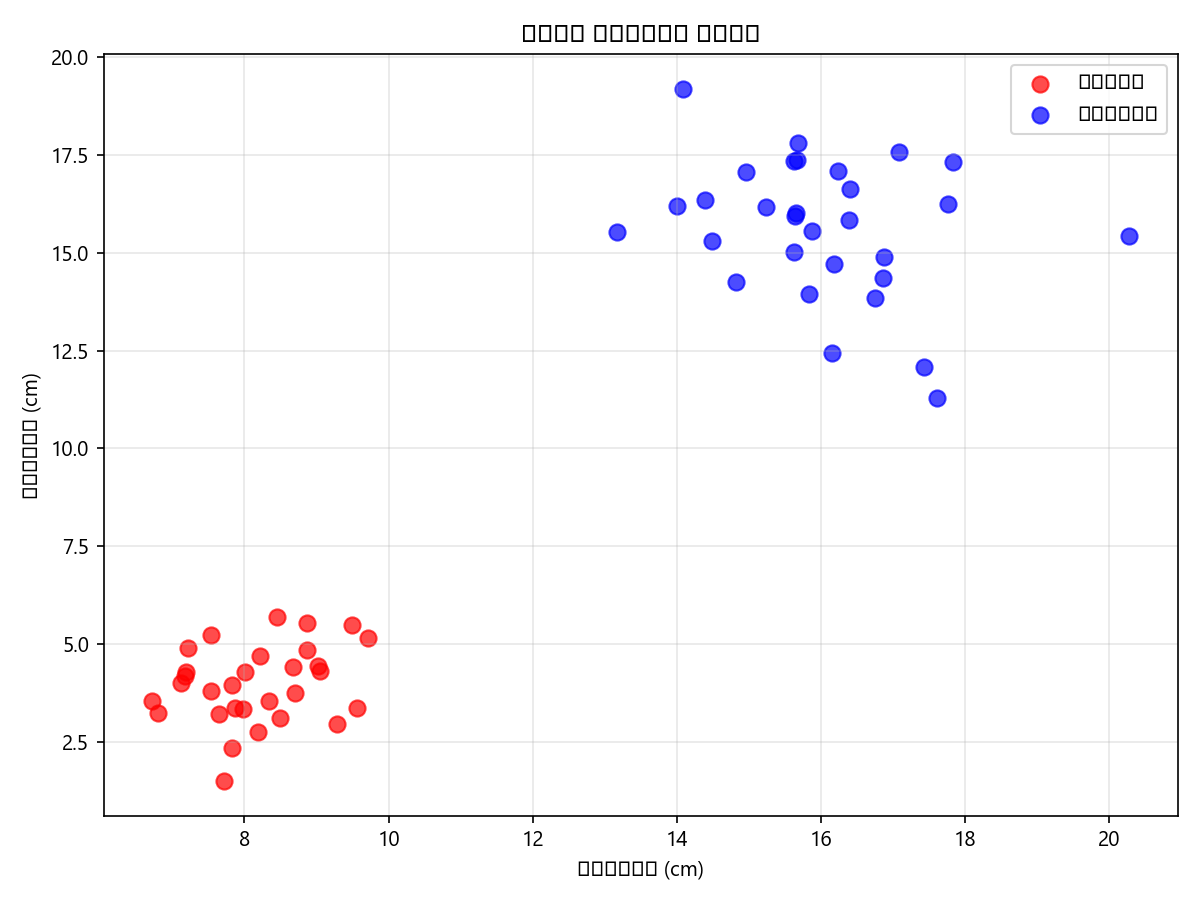

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fist_w, fist_h, c='red', label='Кулак', s=60, alpha=0.7)
ax.scatter(palm_w, palm_h, c='blue', label='Долоня', s=60, alpha=0.7)
ax.set_xlabel('Ширина (cm)')
ax.set_ylabel('Висота (cm)')
ax.set_title('Дані жестів руки')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data_visualization.png', dpi=150)
plt.close()
display(Image('data_visualization.png'))

## 3. k-NN класифікатор

In [4]:
def euclidean_dist(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def knn_predict(train_X, train_y, point, k=3):
    distances = sorted([(euclidean_dist(point, p), train_y[i]) for i, p in enumerate(train_X)])
    votes = {}
    for _, label in distances[:k]:
        votes[label] = votes.get(label, 0) + 1
    return max(votes, key=votes.get)

def shuffle_data(X, y, rng):
    indices = list(range(len(X)))
    for i in range(len(indices)-1, 0, -1):
        j = int(rng.random() * (i+1))
        indices[i], indices[j] = indices[j], indices[i]
    return [X[i] for i in indices], [y[i] for i in indices]

# 1) Базова перевірка на даних з попереднього блоку (train/test split)
rng2 = RNG(123)
X_shuf, y_shuf = shuffle_data(X, y, rng2)
split = int(0.8 * len(X))
train_X, test_X = X_shuf[:split], X_shuf[split:]
train_y, test_y = y_shuf[:split], y_shuf[split:]

print(f"Тренування: {len(train_X)}, Тест: {len(test_X)}")

results = []
for k in [1, 3, 5, 7]:
    correct = sum(1 for i, p in enumerate(test_X) if knn_predict(train_X, train_y, p, k) == test_y[i])
    acc = correct / len(test_y)
    results.append((k, acc))
    print(f"k={k}: Точність = {acc*100:.1f}%")

# 2) Експеримент: тестові дані для 2 класів і для 3 класів

def generate_class_with_rng(rng_obj, n, cw, ch, sw, sh):
    return [(rng_obj.gauss(cw, sw), rng_obj.gauss(ch, sh)) for _ in range(n)]

def evaluate_knn(train_X, train_y, test_X, test_y, k_values):
    out = []
    for k in k_values:
        correct = 0
        for i, p in enumerate(test_X):
            if knn_predict(train_X, train_y, p, k) == test_y[i]:
                correct += 1
        out.append((k, correct / len(test_y)))
    return out

print("\n" + "=" * 60)
print("Експериментальна перевірка на окремих тестових даних")
print("=" * 60)

# (1) Два класи: кулак/долоня
train_rng = RNG(1001)
test_rng = RNG(2002)

train_f = generate_class_with_rng(train_rng, 60, 8, 4, 0.8, 0.9)
train_p = generate_class_with_rng(train_rng, 60, 16, 16, 1.5, 1.8)
test_f = generate_class_with_rng(test_rng, 30, 8, 4, 0.8, 0.9)
test_p = generate_class_with_rng(test_rng, 30, 16, 16, 1.5, 1.8)

train2_X = train_f + train_p
train2_y = [0] * len(train_f) + [1] * len(train_p)
test2_X = test_f + test_p
test2_y = [0] * len(test_f) + [1] * len(test_p)

res2 = evaluate_knn(train2_X, train2_y, test2_X, test2_y, [1, 3, 5, 7])
for k, acc in res2:
    print(f"[2 класи] k={k}: точність = {acc*100:.1f}%")

# (2) Три класи: додаємо «Знак перемоги» як окремий клас
train_rng3 = RNG(3003)
test_rng3 = RNG(4004)

train_v = generate_class_with_rng(train_rng3, 60, 10, 20, 1.5, 2.0)
test_v = generate_class_with_rng(test_rng3, 30, 10, 20, 1.5, 2.0)

train3_X = train_f + train_p + train_v
train3_y = [0] * len(train_f) + [1] * len(train_p) + [2] * len(train_v)
test3_X = test_f + test_p + test_v
test3_y = [0] * len(test_f) + [1] * len(test_p) + [2] * len(test_v)

res3 = evaluate_knn(train3_X, train3_y, test3_X, test3_y, [1, 3, 5, 7])
for k, acc in res3:
    print(f"[3 класи] k={k}: точність = {acc*100:.1f}%")


Тренування: 48, Тест: 12
k=1: Точність = 100.0%
k=3: Точність = 100.0%
k=5: Точність = 100.0%
k=7: Точність = 100.0%

Експериментальна перевірка на окремих тестових даних
[2 класи] k=1: точність = 100.0%
[2 класи] k=3: точність = 100.0%
[2 класи] k=5: точність = 100.0%
[2 класи] k=7: точність = 100.0%
[3 класи] k=1: точність = 98.9%
[3 класи] k=3: точність = 98.9%
[3 класи] k=5: точність = 100.0%
[3 класи] k=7: точність = 100.0%


C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2209566265.py:20: UserWarning: Glyph 1064 (\N{CYRILLIC CAPITAL LETTER SHA}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2209566265.py:20: UserWarning: Glyph 1080 (\N{CYRILLIC SMALL LETTER I}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2209566265.py:20: UserWarning: Glyph 1088 (\N{CYRILLIC SMALL LETTER ER}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2209566265.py:20: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2209566265.py:20: UserWarning: Glyph 1072 (\N{CYRILLIC SMALL LETTER A}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2209566265.py:20: UserWarning: Glyph 1042 (\

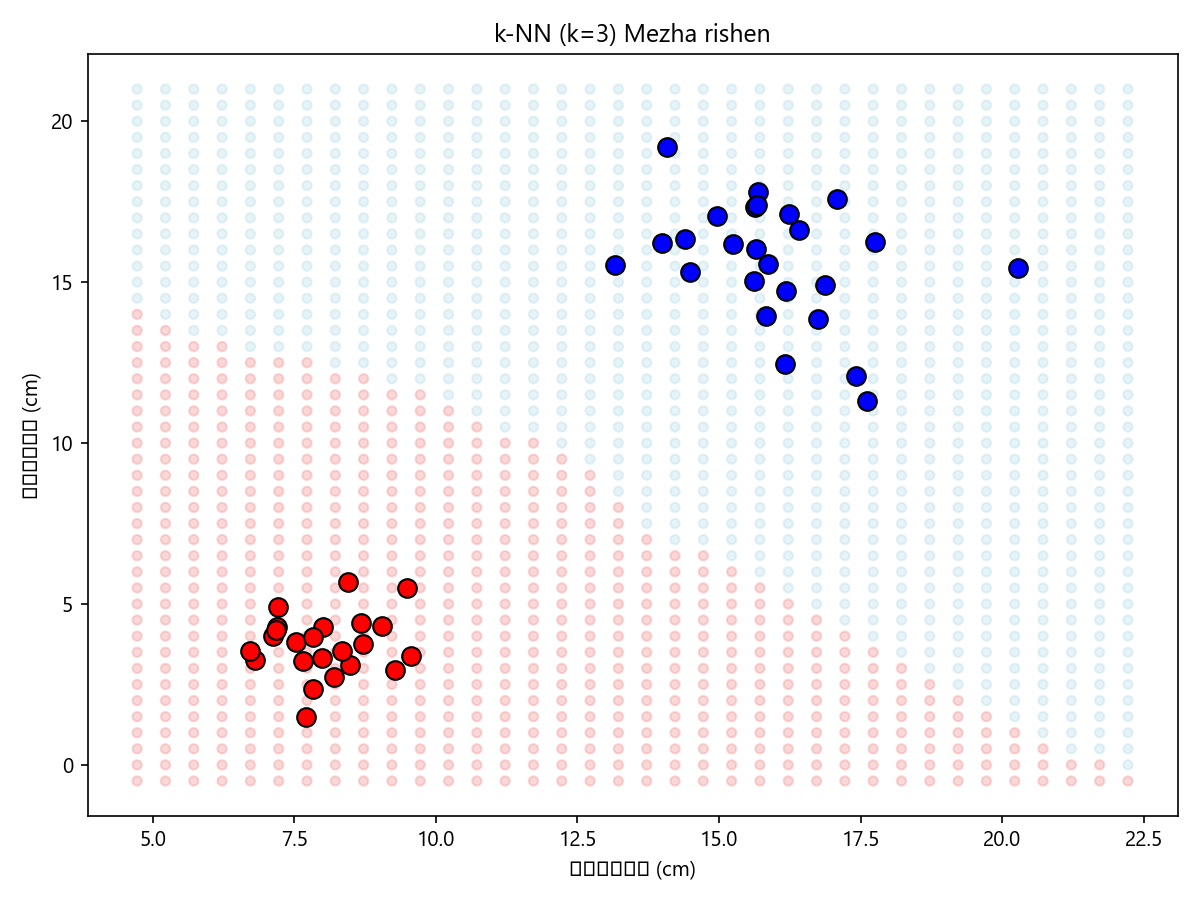

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
x_min, x_max = min(p[0] for p in X) - 2, max(p[0] for p in X) + 2
y_min, y_max = min(p[1] for p in X) - 2, max(p[1] for p in X) + 2
grid_x, grid_y, grid_c = [], [], []
xx = x_min
while xx <= x_max:
    yy = y_min
    while yy <= y_max:
        pred = knn_predict(train_X, train_y, (xx, yy), 3)
        grid_x.append(xx); grid_y.append(yy)
        grid_c.append('lightcoral' if pred == 0 else 'lightblue')
        yy += 0.5
    xx += 0.5
ax.scatter(grid_x, grid_y, c=grid_c, s=20, alpha=0.3)
for point, label in zip(train_X, train_y):
    ax.scatter(point[0], point[1], c='red' if label == 0 else 'blue', s=80, edgecolors='black')
ax.set_xlabel('Ширина (cm)')
ax.set_ylabel('Висота (cm)')
ax.set_title('k-NN (k=3) Mezha rishen')
plt.tight_layout()
plt.savefig('knn_boundary.png', dpi=150)
plt.close()
display(Image('knn_boundary.png'))

## 4. Проблема класу «Знак перемоги»

Якщо збільшити кількість класів у задачі k-NN з 2 до 3 та додати клас **«Знак перемоги»**, то класифікація в просторі ознак 
\((w, h)\) ускладнюється: новий клас може потрапляти в області, близькі до інших жестів, і це призводить до перекриття.

**Практичне вирішення для k-NN:** додати приклади жесту «Знак перемоги» до **тренувальної вибірки** як окремий клас. 
Алгоритм k-NN є багатокласовим за своєю природою (через голосування сусідів), тому він може працювати і з 3+ класами, 
якщо тренувальні дані містять приклади кожного класу.

Водночас, якщо використовувати лише 2D-ознаки \((w, h)\), то для складніших жестів цього може бути недостатньо. 
Для більш надійного розрізнення жестів доцільно розширювати опис ознак (наприклад: кількість пальців, кути між пальцями, 
морфологічні характеристики форми тощо).

**Недоліки при додаванні класу "Знак перемоги":**
1. Проміжні розміри (між кулаком і долонею)
2. Ширина/висота не розрізняють конфігурацію пальців
3. Потрібні додаткові ознаки: кількість пальців, кути

C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2881403926.py:14: UserWarning: Glyph 1064 (\N{CYRILLIC CAPITAL LETTER SHA}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2881403926.py:14: UserWarning: Glyph 1080 (\N{CYRILLIC SMALL LETTER I}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2881403926.py:14: UserWarning: Glyph 1088 (\N{CYRILLIC SMALL LETTER ER}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2881403926.py:14: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2881403926.py:14: UserWarning: Glyph 1072 (\N{CYRILLIC SMALL LETTER A}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\2881403926.py:14: UserWarning: Glyph 1042 (\

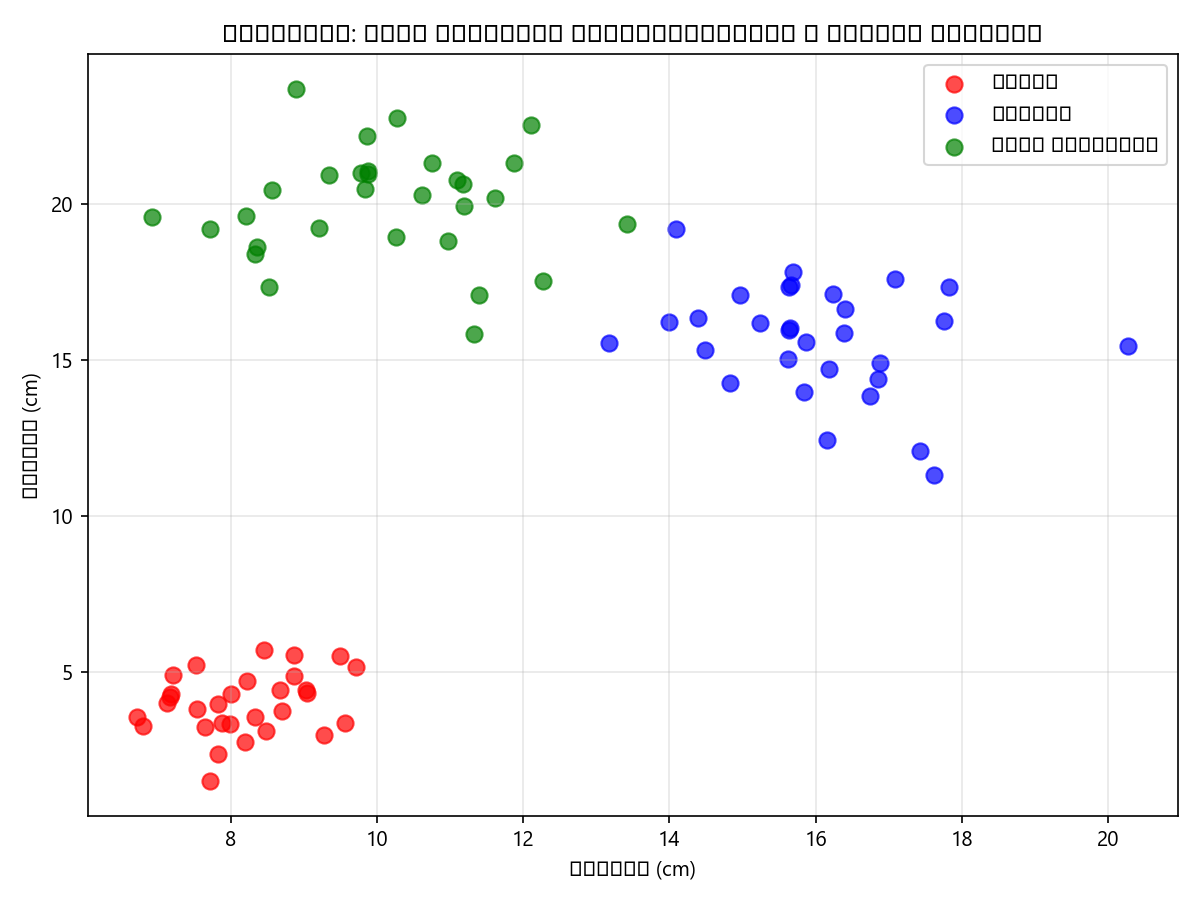

Поява 3-го класу ускладнює задачу: при поточних 2D ознаках (w, h) межі класів можуть перекриватися.


In [6]:
rng3 = RNG(777)
# Victory sign: 10x20cm illustrative box
victory_data = [(rng3.gauss(10, 1.5), rng3.gauss(20, 2.0)) for _ in range(30)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fist_w, fist_h, c='red', label='Кулак', s=60, alpha=0.7)
ax.scatter(palm_w, palm_h, c='blue', label='Долоня', s=60, alpha=0.7)
ax.scatter([p[0] for p in victory_data], [p[1] for p in victory_data], c='green', label='Знак перемоги', s=60, alpha=0.7)
ax.set_xlabel('Ширина (cm)')
ax.set_ylabel('Висота (cm)')
ax.set_title('Проблема: Знак перемоги перекривається з іншими класами')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('victory_problem.png', dpi=150)
plt.close()
display(Image('victory_problem.png'))
print("Поява 3-го класу ускладнює задачу: при поточних 2D ознаках (w, h) межі класів можуть перекриватися.")

## 5. k-means кластеризація

In [7]:
def kmeans(data, k, max_iter=100):
    rng_km = RNG(42 + k)
    indices = list(range(len(data)))
    for i in range(len(indices)-1, 0, -1):
        j = int(rng_km.random() * (i+1))
        indices[i], indices[j] = indices[j], indices[i]
    centroids = [data[i] for i in indices[:k]]
    for _ in range(max_iter):
        clusters = [[] for _ in range(k)]
        labels = []
        for point in data:
            distances = [euclidean_dist(point, c) for c in centroids]
            nearest = distances.index(min(distances))
            clusters[nearest].append(point)
            labels.append(nearest)
        new_centroids = []
        for i, cluster in enumerate(clusters):
            if cluster:
                new_centroids.append((sum(p[0] for p in cluster)/len(cluster), sum(p[1] for p in cluster)/len(cluster)))
            else:
                new_centroids.append(centroids[i])
        if new_centroids == centroids: break
        centroids = new_centroids
    return labels, centroids

def compute_wcss(data, labels, centroids):
    return sum(euclidean_dist(point, centroids[labels[i]])**2 for i, point in enumerate(data))

C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:19: UserWarning: Glyph 1064 (\N{CYRILLIC CAPITAL LETTER SHA}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:19: UserWarning: Glyph 1080 (\N{CYRILLIC SMALL LETTER I}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:19: UserWarning: Glyph 1088 (\N{CYRILLIC SMALL LETTER ER}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:19: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:19: UserWarning: Glyph 1072 (\N{CYRILLIC SMALL LETTER A}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:19: UserWarning: Glyph 1042 (\

C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:20: UserWarning: Glyph 1064 (\N{CYRILLIC CAPITAL LETTER SHA}) missing from font(s) Segoe UI Emoji.
  plt.savefig('kmeans_results.png', dpi=150)
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:20: UserWarning: Glyph 1088 (\N{CYRILLIC SMALL LETTER ER}) missing from font(s) Segoe UI Emoji.
  plt.savefig('kmeans_results.png', dpi=150)
C:\Users\Pavel\AppData\Local\Temp\ipykernel_33032\4205277493.py:20: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from font(s) Segoe UI Emoji.
  plt.savefig('kmeans_results.png', dpi=150)


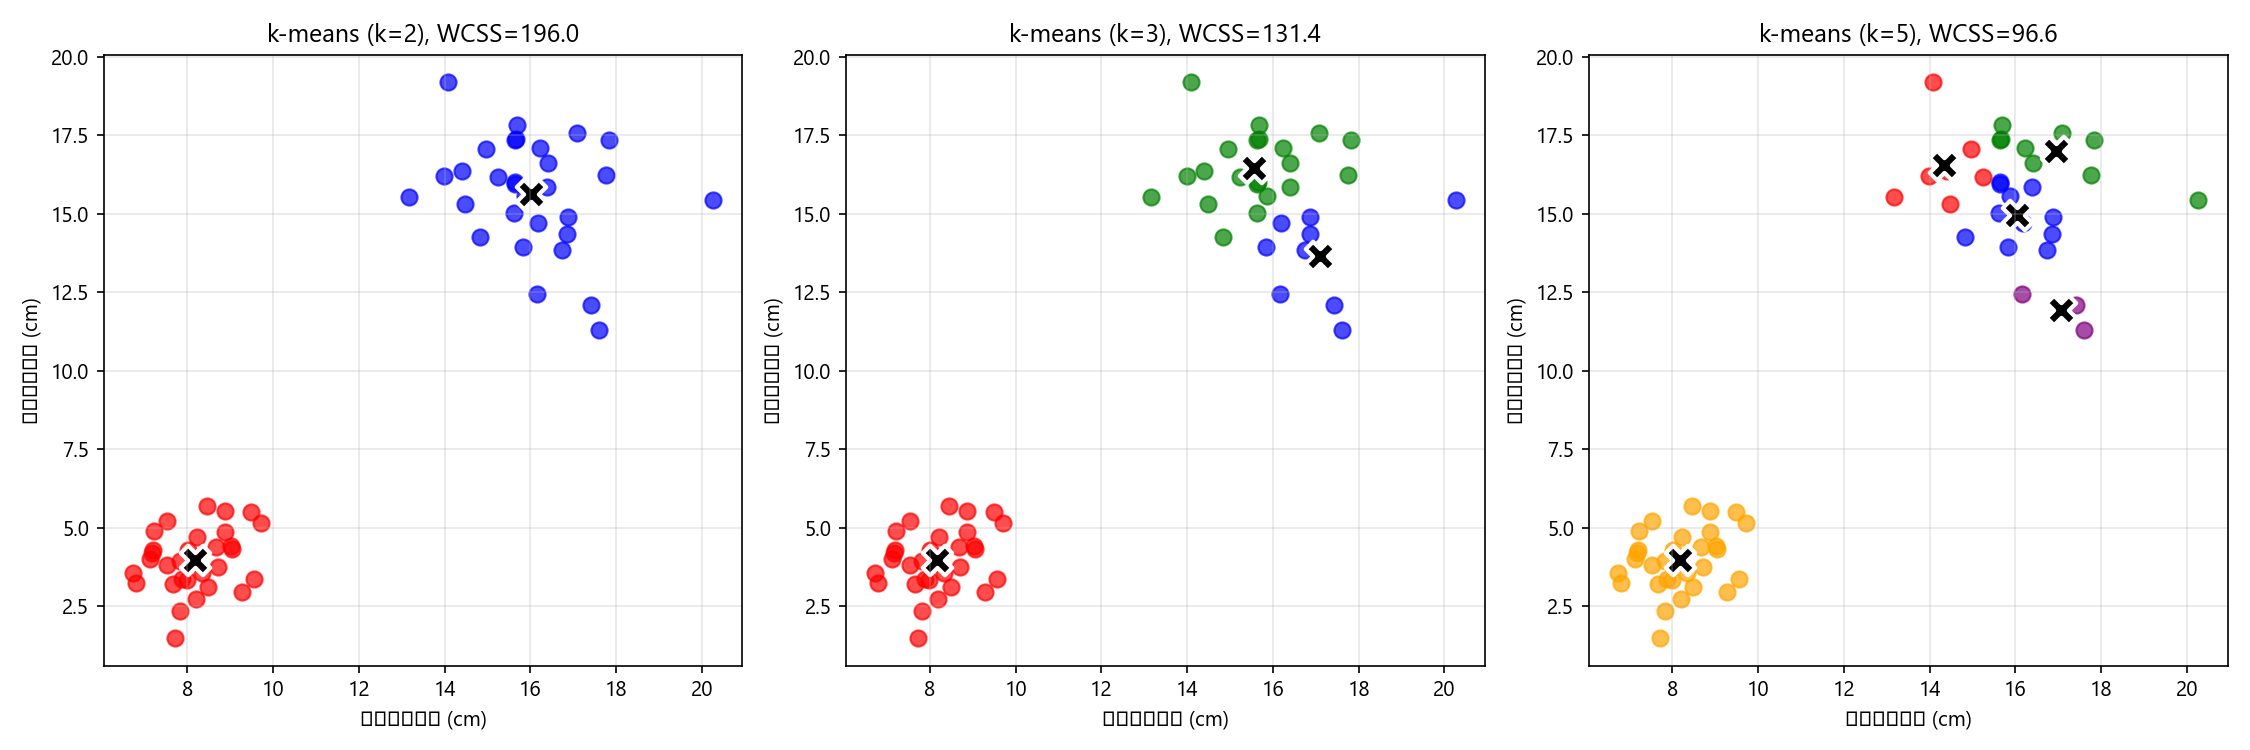

k=2: WCSS = 196.01
k=3: WCSS = 131.40
k=5: WCSS = 96.59


In [8]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
wcss_values = []

for idx, k in enumerate([2, 3, 5]):
    labels, centroids = kmeans(X, k)
    wcss = compute_wcss(X, labels, centroids)
    wcss_values.append((k, wcss))
    ax = axes[idx]
    for i, point in enumerate(X):
        ax.scatter(point[0], point[1], c=colors[labels[i]], s=60, alpha=0.7)
    for c in centroids:
        ax.scatter(c[0], c[1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.set_xlabel('Ширина (cm)')
    ax.set_ylabel('Висота (cm)')
    ax.set_title(f'k-means (k={k}), WCSS={wcss:.1f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_results.png', dpi=150)
plt.close()
display(Image('kmeans_results.png'))

for k, wcss in wcss_values:
    print(f"k={k}: WCSS = {wcss:.2f}")

## 6. Висновки

### k-NN:
- Ефективно розділяє кулак та долоню (точність 100%)
- Додавання "знаку перемоги" знижує точність

### k-means:
- k=2 найкраще відповідає реальним класам
- WCSS зменшується з k

### Проблема знаку перемоги:
- Проміжні розміри перекриваються
- Потрібні додаткові ознаки (кількість пальців, кути)

In [9]:
print("="*50)
print("Підсумок")
print("="*50)
print(f"\nНабір даних: {len(X)} зразків (Кулак: 30, Долоня: 30)")
print(f"Ознаки: Ширина, Висота (cm)")
print(f"\nk-NN найкраща точність: {max(results, key=lambda x: x[1])[1]*100:.1f}%")
print(f"\nk-means WCSS:")
for k, wcss in wcss_values:
    print(f"  k={k}: {wcss:.2f}")
print("\nВисновок: 2D ознаки (ширина, висота) достатні для")
print("класифікації Кулак/Долоня, але недостатні для Знаку перемоги.")

Підсумок

Набір даних: 60 зразків (Кулак: 30, Долоня: 30)
Ознаки: Ширина, Висота (cm)

k-NN найкраща точність: 100.0%

k-means WCSS:
  k=2: 196.01
  k=3: 131.40
  k=5: 96.59

Висновок: 2D ознаки (ширина, висота) достатні для
класифікації Кулак/Долоня, але недостатні для Знаку перемоги.
